In [1]:
import h5py
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Building custom training dataset
## Suppose that you have many waveforms and corresponding manual labels. And you can access them by filenames or indexs.

In [2]:
# config params
cfgs = dict()
# the waveform length you want to keep
cfgs['waveform_length'] = 6000
cfgs['original_data_folder'] = None
cfgs['save_hdf5_path'] = './toy_example.hdf5'
cfgs['save_csv_path']  = './toy_example.csv'

In [3]:
# the function that takes a filename or index as input and returns corresponding waveform and label as the output
def get_custom_data_and_label(filename=None, cfgs=None):
    # data is a cfgs['waveform_length']  × 3 array
    # here we set Z N E ➡ 0 1 2
    data = np.zeros([cfgs['waveform_length'],3])
    
    # read stream file and labels here via filename (replace the random generated data)
    st = np.random.normal(0,1,size=[cfgs['waveform_length'],3])
    P_label = np.random.randint(low=2000, high=cfgs['waveform_length'] - 2000)
    S_label = np.random.randint(low=P_label,high=cfgs['waveform_length'] - 2000)
    st[:P_label,:] = 0.0
    
    data[:,:] = st[:,:]
    
    # resample and slice stream here if needed
    
    return data, P_label, S_label

In [4]:
# create DataFrame for csv file
csv_data = pd.DataFrame(columns=['key', 'P', 'S'])
# create HDF5 for hdf5 file
if os.path.exists(cfgs['save_hdf5_path']):
    os.remove(cfgs['save_hdf5_path'])
hdf5_file = h5py.File(cfgs['save_hdf5_path'], 'a')
hdf5_file.create_group('earthquake')
hdf5_file.close()

# total trace number
total_trace_num = 100
for trace_dx in range(total_trace_num):
    # define a unique key here
    key = '{:}'.format(trace_dx).rjust(8,'0')
    
    # get a waveform file
    waveform_filename = None
    
    data, P_label, S_label = get_custom_data_and_label(waveform_filename, cfgs)
    
    hdf5_file = h5py.File(cfgs['save_hdf5_path'], 'a')
    # if you are using the raw count data, you can set dtype to np.int32 to save space
    dsf = hdf5_file.create_dataset('earthquake/' + key,
                            [cfgs['waveform_length'],3],
                            data  = data,
                            dtype = np.float32)
    dsf.attrs["trace_key"] = key
    dsf.attrs["P"] = P_label
    dsf.attrs["S"] = S_label
    hdf5_file.flush()
    hdf5_file.close()
    csv_data.loc[len(csv_data.index)] = [key, P_label, S_label]

csv_data.to_csv(cfgs['save_csv_path'])

# Inspect the dataset

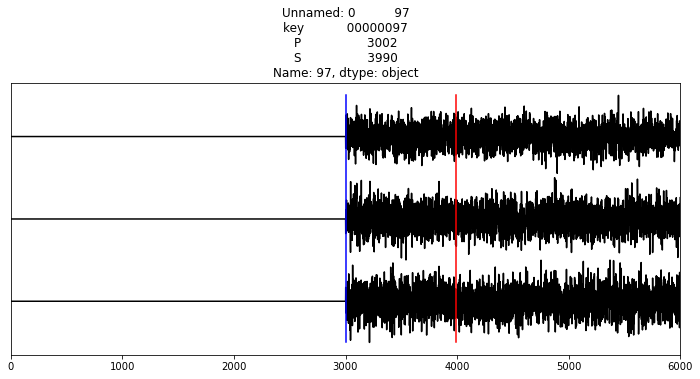

In [5]:
csv_data = pd.read_csv(cfgs['save_csv_path'], dtype = {'key': str})
random_line = csv_data.iloc[np.random.randint(len(csv_data))]
P_label = random_line['P']
S_label = random_line['S']
# get data
with h5py.File(cfgs['save_hdf5_path'], 'r') as h5_file:
    data = h5_file.get('earthquake/' + random_line['key'])
    data = np.asarray(data)
    
plt.figure(figsize=(12,5))
for chdx in range(3):
    data[:,chdx] -= np.mean(data[:,chdx])
    data[:,chdx] /= np.max(np.abs(data[:,chdx]))
    plt.plot(data[:,chdx]+2*chdx, color='k')
plt.plot([P_label,P_label],[-1,5],color='b')
plt.plot([S_label,S_label],[-1,5],color='r')
plt.yticks([])
plt.xlim([0,cfgs['waveform_length']])
plt.title('{}'.format(str(random_line)))
plt.show()
plt.close()

# Load trained model for picking

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [7]:
import tensorflow as tf

In [8]:
# not a well trained model, only for showing how to predict
P_picker = tf.keras.models.load_model('../trained_models/PickNet_P__0003.hdf5', compile=False)

/public/home/zhaoming/guochang/miniconda3/envs/DiTingDevEnv/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:1028: UserWarning: src.model.custom_layers is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '
2021-12-30 18:22:31.889606: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-30 18:22:32.040858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2021-12-30 18:22:32.041971: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-30 18:22:32.047796: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library 

2021-12-30 18:22:35.809426: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-12-30 18:22:37.780298: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


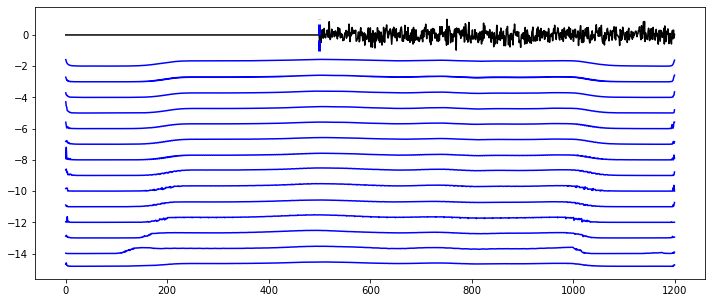

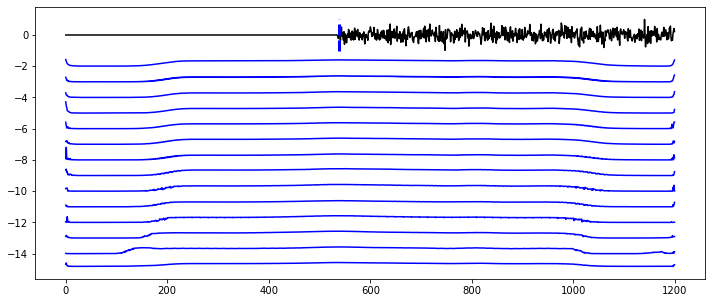

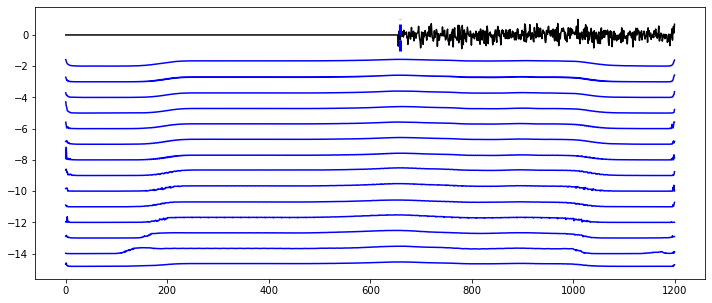

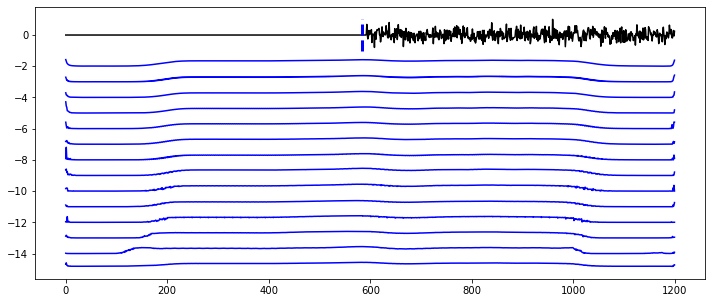

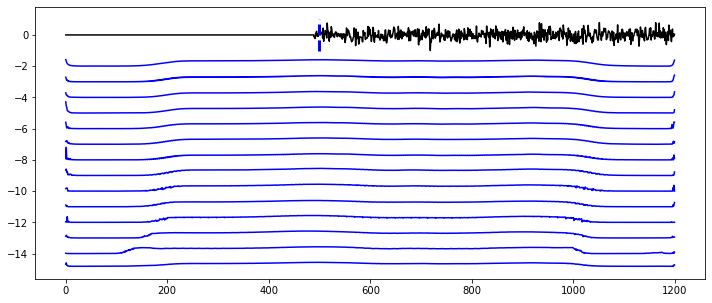

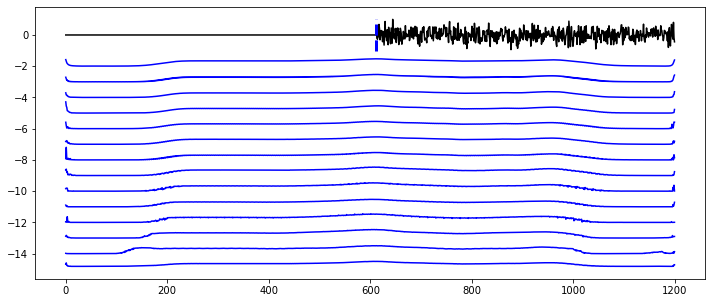

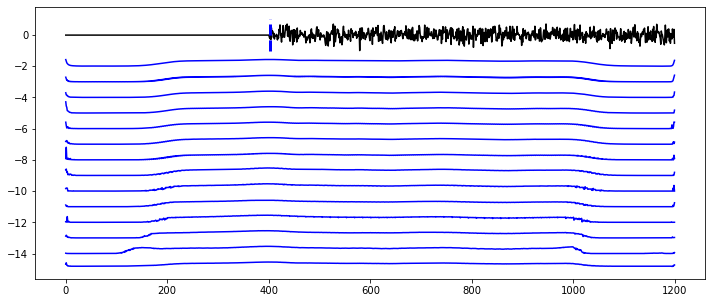

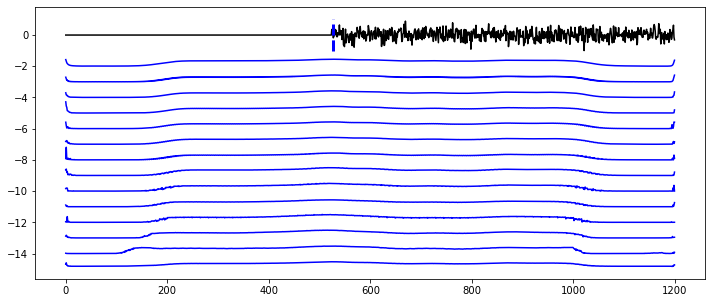

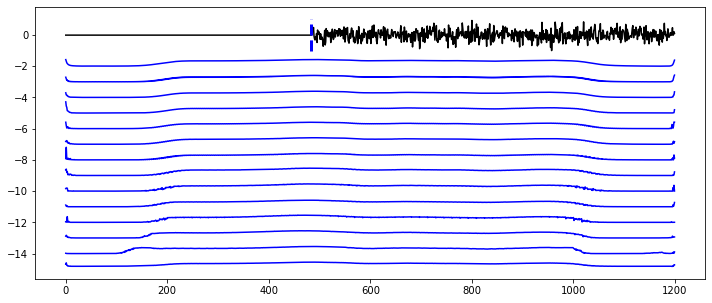

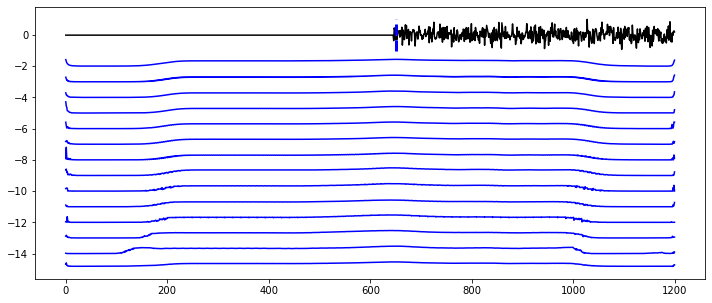

In [9]:
# simple predict example
batch_size = 10
total_batch_num = int( len(csv_data) / batch_size )
csv_data = pd.read_csv(cfgs['save_csv_path'], dtype = {'key': str})
# can change to generator to speed up predicting
for pred_dx in range(total_batch_num):
    input_batch = np.zeros([batch_size, 1200, 1])
    for ins_dx in range(batch_size):
        line_dx = ins_dx + pred_dx * batch_size
        if line_dx >= len(csv_data):
            continue
        else:
            cur_line = csv_data.iloc[np.random.randint(len(csv_data))]
            
            # get theoretical arrival time or reference time to set time window
            theo_time = cur_line['P'] + np.random.randint(low=-300,high=300)
            # get data
            with h5py.File(cfgs['save_hdf5_path'], 'r') as h5_file:
                data = h5_file.get('earthquake/' + cur_line['key'])
                data = np.asarray(data)
            input_batch[ins_dx,:,:] = data[theo_time-600:theo_time+600,0:1]
            input_batch[ins_dx,:,:] -= np.mean(input_batch[ins_dx,:,:])
            input_batch[ins_dx,:,:] /= np.max(np.abs(input_batch[ins_dx,:,:]))
    res = P_picker.predict(input_batch)
    # check results
    check_id = np.random.randint(batch_size)
    plt.figure(figsize=(12,5))
    plt.plot(input_batch[check_id,:,0], color='k')
    
    for res_dx in range(14):
        plt.plot(res[res_dx][check_id,:,0]-res_dx*1.0 - 2.0,color='b')
    plt.plot([np.argmax(res[-1][check_id,:,0]),np.argmax(res[-1][check_id,:,0])], [-1,1],color='b',linewidth=3,linestyle='--')
    #plt.yticks([])
    #plt.xticks()
    plt.show()
    plt.close()